In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import warnings
# suppress warnings
warnings.filterwarnings("ignore")

import src.utils.setup_figures as figures
import src.utils.basic as utils

### Load Configs

In [18]:
from config import dir_config, main_config

base_data_dir = Path(dir_config.data.base)
raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)


session_metadata = pd.read_csv(Path(raw_dir, "subject_metadata.csv"), index_col=None)


#### Bradykinesia scoring is calculted as the average of bradikinesia, rigidity and axial symptoms
Bradykinesia - sum of item 3.4, finger tapping; item 3.5, hand movements; item 3.6, pronation-supination movements of hands; item 3.7, toe tapping; item 3.8, leg agility; item 3.9, arising from chair; item 3.13, posture; and item 3.14,
body bradykinesia;

Rigidity (sum of item 3.3. [Neck, Upper Limbs and Lower Limbs]);

axial symptoms (sum of item 3.10, gait; item 3.11, freezing of gait; and item 3.12, postural stability)

# Load Aggregate data and preprocess trials

In [19]:
aggregate_data = pd.read_csv(Path(raw_dir, "aggregate_data.csv"), index_col=None)


#### Fill out the subject_metadata prior based on aggregate_data

In [20]:
for subject, medication in sorted(list(zip(session_metadata['subject_id'], session_metadata['treatment'])), key = lambda x: x[0]):
    # find the corresponding row in the aggregate data
    session_data = aggregate_data[(aggregate_data['subject'] == subject) & (aggregate_data['medication'] == medication.lower())]
    prior = np.unique(session_data['prior'])
    prior = prior[prior != 'eq']
    
    # in session_metadata, where subject and medication matches, update the prior
    current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == medication)].index
    session_metadata.loc[current_idx, 'prior_condition'] = prior[0]
    session_metadata.loc[current_idx, 'file_name'] = np.unique(session_data['session_name'])[0]    

In [21]:
print(session_metadata.isnull().sum())

# replace null with NaN
session_metadata.replace('', np.nan, inplace=True)
session_metadata.replace('NA', np.nan, inplace=True)

# replace categorical values with integers
session_metadata['were_diskinesia_present'] = session_metadata['were_diskinesia_present'].map({'yes': 1, 'no': 0})
session_metadata['did_movement_interfere_with_ratings'] = session_metadata['did_movement_interfere_with_ratings'].map({'yes': 1, 'no': 0})

subject_id                              0
prior_condition                         0
treatment                               0
off_med_first                          14
file_name                               0
is_tremor_dominant                     46
bradykinesia_score                     62
tremor_score                           62
sMMSE                                  46
BDI                                    47
BAI                                    46
UPDRS                                  18
speech                                 30
facial_expression                      30
rigidity_neck                          30
rigidity_RUE                           30
rigidity_LUE                           30
rigidity_RLE                           33
rigidity_LLE                           33
finger_tap_R                           30
finger_tap_L                           30
hand_movements_R                       30
hand_movements_L                       30
pron_R                            

In [22]:
print("------------- info ----------------")
print(session_metadata.info())
print("\n\n------------- head ----------------\n\n")
print(session_metadata.head())
print("\n\n------------- describe ----------------\n\n")
print(session_metadata.describe())
print("\n\n------------- dtypes ----------------\n\n")
print(session_metadata.dtypes)
print("\n\n------------- shape ----------------\n\n")
print(session_metadata.shape)

------------- info ----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 50 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   subject_id                           62 non-null     object 
 1   prior_condition                      62 non-null     object 
 2   treatment                            62 non-null     object 
 3   off_med_first                        48 non-null     float64
 4   file_name                            62 non-null     object 
 5   is_tremor_dominant                   16 non-null     float64
 6   bradykinesia_score                   0 non-null      float64
 7   tremor_score                         0 non-null      float64
 8   sMMSE                                16 non-null     float64
 9   BDI                                  15 non-null     float64
 10  BAI                                  16 non-null     float64
 11

In [23]:
# Extract the relevant tremor variables that exist in the DataFrame columns
relevant_tremor_vars = [var for var in main_config.categorization.tremor if var in session_metadata.columns]
relevant_bradykinesia_vars = [var for var in main_config.categorization.bradykinesia if var in session_metadata.columns]


for sub in session_metadata['subject_id'].unique():
    # get indices of the subject
    idx = session_metadata[session_metadata['subject_id'] == sub].index
    
    # get index where treatment is off
    off_idx = session_metadata[(session_metadata['subject_id'] == sub) & (session_metadata['treatment'] == 'OFF')].index
    
    # print(f"Subject {sub}: Tremor: {session_metadata.loc[off_idx, relevant_tremor_vars]}, Bradykinesia: {session_metadata.loc[off_idx, relevant_bradykinesia_vars]}")

    tremor_score = np.nanmean(session_metadata.loc[off_idx, relevant_tremor_vars], axis=1)
    bradykinesia_score = np.nanmean(session_metadata.loc[off_idx, relevant_bradykinesia_vars], axis=1)
    categorization_score = tremor_score / bradykinesia_score    
    session_metadata.loc[idx, 'tremor_score'] = tremor_score[0]
    session_metadata.loc[idx, 'bradykinesia_score'] = bradykinesia_score[0]
    session_metadata.loc[idx, 'categorization_score'] = categorization_score[0]
    
    

##### Data rejection

In [24]:
valid_data = aggregate_data[aggregate_data['is_valid'] == 1]
# chose trials with minimum reaction time from main_config
valid_data = valid_data[valid_data['reaction_time'] >= main_config.behavior.min_rt]
valid_data = valid_data[valid_data['prior'] != 'eq']
valid_data['prior_color'].loc[valid_data['prior'] == 'eq'] = None
valid_data['prior_direction'].loc[valid_data['prior'] == 'eq'] = np.NaN

# remove data from subjects listed in main_config.manual_rejection
valid_data = valid_data[~valid_data['subject'].isin(main_config.manual_rejection)]

#### Direction and color conversion to prior condition

In [25]:
# Ensure valid_data is a DataFrame you intend to modify directly
left_prior_idx = valid_data['prior_direction'] == 'left'
right_prior_idx = valid_data['prior_direction'] == 'right'
green_prior_idx = valid_data['prior_color'] == 'green'
red_prior_idx = valid_data['prior_color'] == 'red'

# Renaming directions based on prior direction
valid_data.loc[left_prior_idx, 'target'] = valid_data.loc[left_prior_idx, 'target'].map({'left': 1, 'right': -1})
valid_data.loc[left_prior_idx, 'choice'] = valid_data.loc[left_prior_idx, 'choice'].map({'left': 1, 'right': -1})
valid_data.loc[right_prior_idx, 'target'] = valid_data.loc[right_prior_idx, 'target'].map({'left': -1, 'right': 1})
valid_data.loc[right_prior_idx, 'choice'] = valid_data.loc[right_prior_idx, 'choice'].map({'left': -1, 'right': 1})

# Renaming colors based on prior color
valid_data.loc[green_prior_idx, 'color'] = valid_data.loc[green_prior_idx, 'color'].map({'green': 1, 'red': -1})
valid_data.loc[red_prior_idx, 'color'] = valid_data.loc[red_prior_idx, 'color'].map({'green': -1, 'red': 1})

valid_data['signed_coherence'] = valid_data['coherence'] * valid_data['target']

#### Rejecting sessions based on allowed lapse rates

In [26]:
sessions = valid_data['session_name'].unique()

reject_sessions = []

for session in sessions:
    session_data = valid_data[valid_data['session_name'] == session]
    for color in [-1, 1]:
        coh, psych, model, _, _, trial_count = utils.get_psychometric_data(session_data[session_data['color'] == color])
        
        # # print(f"Subject: {session} \t\t {model.coefs_['lapse_rate']}, \t{model.coefs_['guess_rate']}")
        # if ((model.coefs_['lapse_rate'] > main_config.behavior.max_lapse_rate)  and model.coefs_['guess_rate'] > main_config.behavior.max_lapse_rate):
        #     reject_sessions.append(session)
        #     print(f"Subject: {session} rejected due to high lapse rate, \t\t {model.coefs_['lapse_rate']}, \t{model.coefs_['guess_rate']}")
        #     # print("Rejected")
        #     continue
        # print(((1-psych[0])*trial_count[0] + psych[-1]*trial_count[-1])/(trial_count[0] + trial_count[-1]))
        accuracy = ((1-psych[0])*trial_count[0] + psych[-1]*trial_count[-1])/(trial_count[0] + trial_count[-1])
        if accuracy < 0.60:
            reject_sessions.append(session)
            print(f"Subject: {session} rejected due to low accuracy {accuracy}")
            continue

valid_data = valid_data[~valid_data['session_name'].isin(reject_sessions)]
    

Subject: Brady_AJL_OFFmeds_gr.mat rejected due to low accuracy 0.56
Subject: Brady_AJL_OFFmeds_gr.mat rejected due to low accuracy 0.4935064935064935
Subject: Brady_LHO_ONmeds_gl.mat rejected due to low accuracy 0.5194805194805194
Subject: Brady_RSH_ONmeds_gl.mat rejected due to low accuracy 0.5633802816901409
Subject: Brady_RSH_ONmeds_gl.mat rejected due to low accuracy 0.5
Subject: Brady_RZA_OFFmeds_gl.mat rejected due to low accuracy 0.5263157894736842
Subject: Brady_RZA_ONmeds_rl.mat rejected due to low accuracy 0.5625
Subject: Brady_SKU_OFFmeds_rr.mat rejected due to low accuracy 0.5066666666666667
Subject: Brady_SKU_OFFmeds_rr.mat rejected due to low accuracy 0.5774647887323944
Subject: Trem_ALE_ONmeds_rr.mat rejected due to low accuracy 0.5875
Subject: Trem_P10_OFFmeds_gl.mat rejected due to low accuracy 0.581081081081081
Subject: Trem_P15_OFFmeds_gr.mat rejected due to low accuracy 0.3888888888888889
Subject: Trem_P15_OFFmeds_gr.mat rejected due to low accuracy 0.54166666666666

In [27]:
# finding subjects who have both on and off medication sessions 
subject_sessions = valid_data.groupby('subject')['medication'].unique()

valid_subjects = []
for subject, sessions in subject_sessions.items():
    if len(sessions) == 2:
        valid_subjects.append(subject)

valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]
valid_session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]

print(f"Number of valid subjects: {len(valid_subjects)}")
print(valid_subjects)
print(f"Number of subjects: {len(valid_data['subject'].unique())}")
print(valid_data['subject'].unique())
print(f"Number of sessions: {len(valid_session_metadata['subject_id'].unique())}")
print(valid_session_metadata['subject_id'].unique())


Number of valid subjects: 31
['BBK', 'BER', 'CG', 'COH', 'DP', 'FUR', 'LBR', 'MAR', 'MBY', 'P1', 'P11', 'P12', 'P13', 'P16', 'P17', 'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'P4', 'P6', 'P7', 'P9', 'PAM', 'RBA', 'RDE', 'RW', 'SGA', 'SMI']
Number of subjects: 31
['CG' 'COH' 'MBY' 'P1' 'P22' 'P23' 'P24' 'PAM' 'RBA' 'RDE' 'RW' 'SGA'
 'BBK' 'BER' 'DP' 'FUR' 'LBR' 'MAR' 'P11' 'P12' 'P13' 'P16' 'P17' 'P18'
 'P19' 'P20' 'P4' 'P6' 'P7' 'P9' 'SMI']
Number of sessions: 31
['P1' 'P4' 'P6' 'P7' 'P9' 'P11' 'P12' 'P13' 'P16' 'P17' 'P18' 'P19' 'P20'
 'P22' 'P23' 'P24' 'CG' 'COH' 'MBY' 'DP' 'FUR' 'LBR' 'MAR' 'SMI' 'PAM'
 'RW' 'SGA' 'BBK' 'BER' 'RBA' 'RDE']


In [28]:
session_metadata['subject_id'].unique()

array(['P1', 'P4', 'P6', 'P7', 'P9', 'P11', 'P12', 'P13', 'P16', 'P17',
       'P18', 'P19', 'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP',
       'FUR', 'LBR', 'MAR', 'SMI', 'PAM', 'RW', 'SGA', 'BBK', 'BER',
       'RBA', 'RDE'], dtype=object)

In [29]:
# adding session_id to each subject off and on medication sessions

subject_sessions = valid_data.groupby('subject')['medication'].unique()

session_metadata['positive_bias'] = np.NaN
session_metadata['positive_bias'] = np.NaN
session_metadata['positive_psych_alpha'] = np.NaN
session_metadata['positive_psych_beta'] = np.NaN
session_metadata['positive_psych_lapse'] = np.NaN
session_metadata['positive_psych_guess'] = np.NaN

session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_bias'] = np.NaN
session_metadata['equal_psych_alpha'] = np.NaN
session_metadata['equal_psych_beta'] = np.NaN
session_metadata['equal_psych_lapse'] = np.NaN
session_metadata['equal_psych_guess'] = np.NaN

for subject, sessions in subject_sessions.items():
    for session in sessions:
        session_data = valid_data[(valid_data['subject'] == subject) & (valid_data['medication'] == session)]
        
        current_idx = session_metadata[(session_metadata['subject_id'] == subject) & (session_metadata['treatment'] == session.upper())].index

        positive_bias, positive_psych_bias, positive_psych_alpha, positive_psych_beta, positive_psych_lapse, positive_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
        equal_bias, equal_psych_bias, equal_psych_alpha, equal_psych_beta, equal_psych_lapse, equal_psych_guess = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
        
        coh, positive_psych, positive_model, _, _, _ = utils.get_psychometric_data(session_data[session_data['color'] == 1])
        coh, equal_psych, equal_model, _, _, _ = utils.get_psychometric_data(session_data[session_data['color'] == -1])
        
        session_metadata.loc[current_idx, 'positive_bias'] = positive_psych[3]
        session_metadata.loc[current_idx, 'positive_psych_bias'] = positive_model.predict(0)
        session_metadata.loc[current_idx, 'positive_psych_alpha'] = positive_model.coefs_['mean']
        session_metadata.loc[current_idx, 'positive_psych_beta'] = positive_model.coefs_['var']
        session_metadata.loc[current_idx, 'positive_psych_lapse'] = positive_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'positive_psych_guess'] = positive_model.coefs_['guess_rate']
        
        session_metadata.loc[current_idx, 'equal_bias'] = equal_psych[3]    
        session_metadata.loc[current_idx, 'equal_psych_bias'] = equal_model.predict(0)
        session_metadata.loc[current_idx, 'equal_psych_alpha'] = equal_model.coefs_['mean']
        session_metadata.loc[current_idx, 'equal_psych_beta'] = equal_model.coefs_['var']
        session_metadata.loc[current_idx, 'equal_psych_lapse'] = equal_model.coefs_['lapse_rate']
        session_metadata.loc[current_idx, 'equal_psych_guess'] = equal_model.coefs_['guess_rate']


### Input decision-behavior parameters into session_metadata

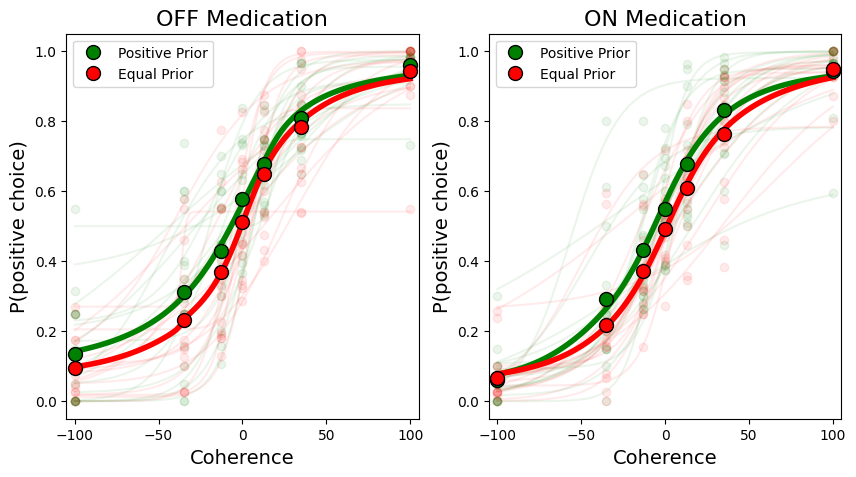

In [30]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subject_alpha = 0.08

sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []


for i, subject in enumerate(valid_subjects):
    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')
    
    subject_metadata = session_metadata.loc[session_metadata['subject_id'] == subject]
    if True and np.sum(np.isnan(subject_metadata['categorization_score'])) == 0:
    
        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat, _ = utils.get_psychometric_data(med_data[med_data['color'] == 1])
            eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat, _ = utils.get_psychometric_data(med_data[med_data['color'] == -1])
            
            if med == 'off':            
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_psych.append(pos_psych)
                sub_off_pos_model.append(pos_model)
                sub_off_pos_x_hat.append(pos_x_hat)
                sub_off_pos_y_hat.append(pos_y_hat)            
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_psych.append(eq_psych)
                sub_off_eq_model.append(eq_model)
                sub_off_eq_x_hat.append(eq_x_hat)
                sub_off_eq_y_hat.append(eq_y_hat)
            elif med == 'on':            
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_psych.append(pos_psych)
                sub_on_pos_model.append(pos_model)
                sub_on_pos_x_hat.append(pos_x_hat)
                sub_on_pos_y_hat.append(pos_y_hat)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_psych.append(eq_psych)
                sub_on_eq_model.append(eq_model)
                sub_on_eq_x_hat.append(eq_x_hat)
                sub_on_eq_y_hat.append(eq_y_hat)
            
            ax[ax_idx].plot(pos_coh, pos_psych, 'go', alpha=subject_alpha)
            ax[ax_idx].plot(pos_x_hat, pos_y_hat, 'g-', alpha=subject_alpha)
            ax[ax_idx].plot(eq_coh, eq_psych, 'ro', alpha=subject_alpha)
            ax[ax_idx].plot(eq_x_hat, eq_y_hat, 'r-', alpha=subject_alpha)

ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), np.mean(sub_off_pos_y_hat, axis=0), 'g-', lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), np.mean(sub_off_eq_y_hat, axis=0), 'r-', lw=4, alpha=1)
ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), 'go', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), 'ro', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), np.mean(sub_on_pos_y_hat, axis=0), 'g-', lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), np.mean(sub_on_eq_y_hat, axis=0), 'r-', lw=4, alpha=1)
ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), 'go', ms=10, mec='k', label='Positive Prior', alpha=1)
ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), 'ro', ms=10, mec='k', label='Equal Prior', alpha=1)

ax[0].set_title(f"OFF Medication", fontsize=16)
ax[0].set_xlabel('Coherence', fontsize=14)
ax[0].set_ylabel('P(positive choice)', fontsize=14)
ax[0].set_xlim(-105, 105)
ax[0].set_ylim(-0.05, 1.05)
ax[0].legend()
ax[1].set_title(f"ON Medication", fontsize=16)
ax[1].set_xlabel('Coherence', fontsize=14)
ax[1].set_ylabel('P(positive choice)', fontsize=14)
ax[1].set_xlim(-105, 105)
ax[1].set_ylim(-0.05, 1.05)
ax[1].legend()



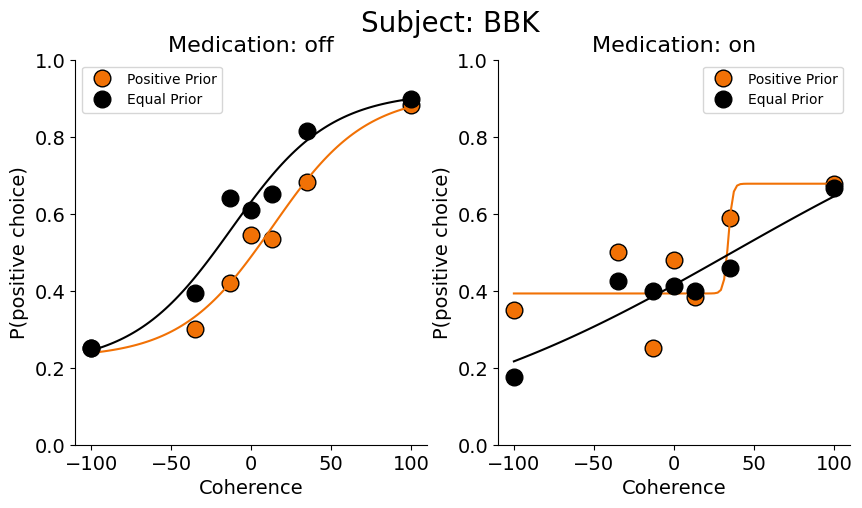

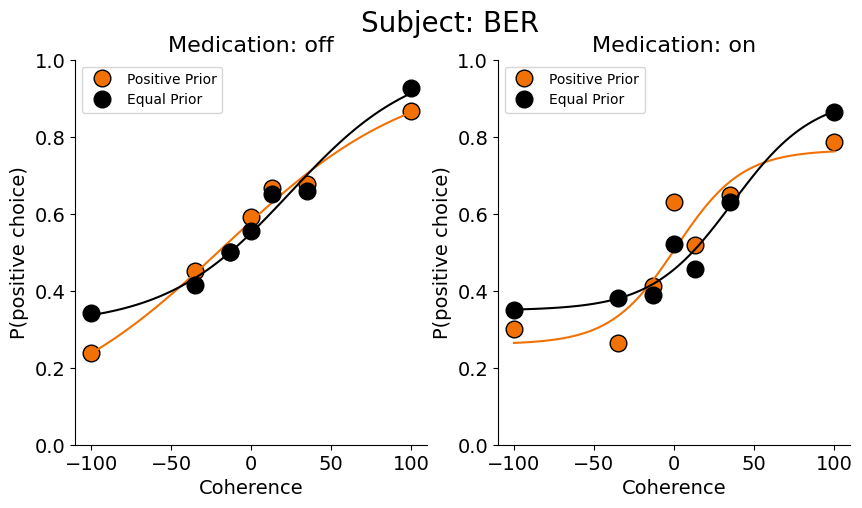

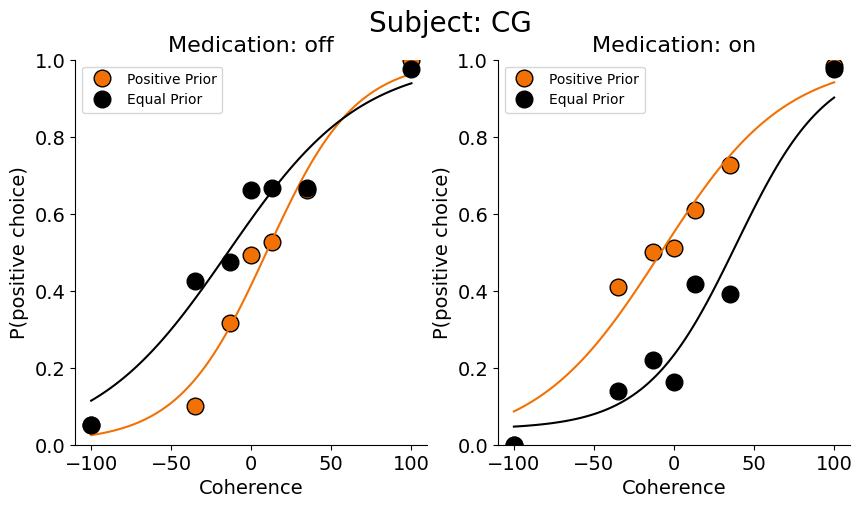

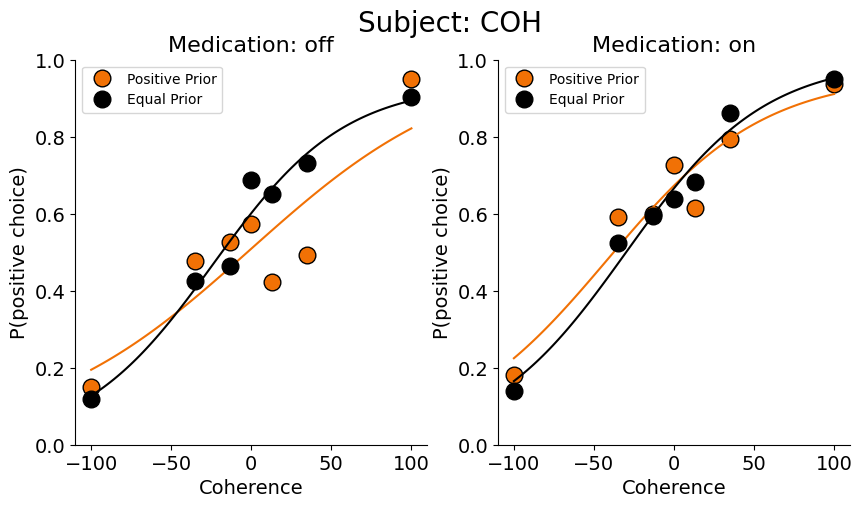

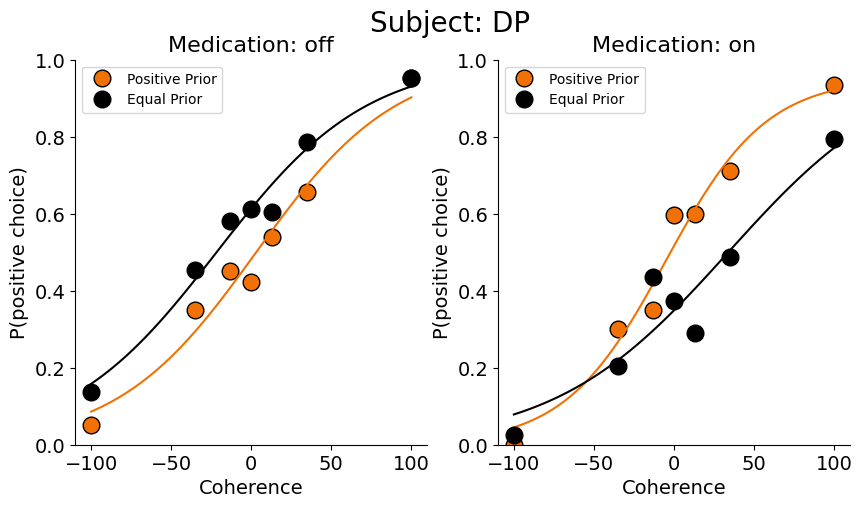

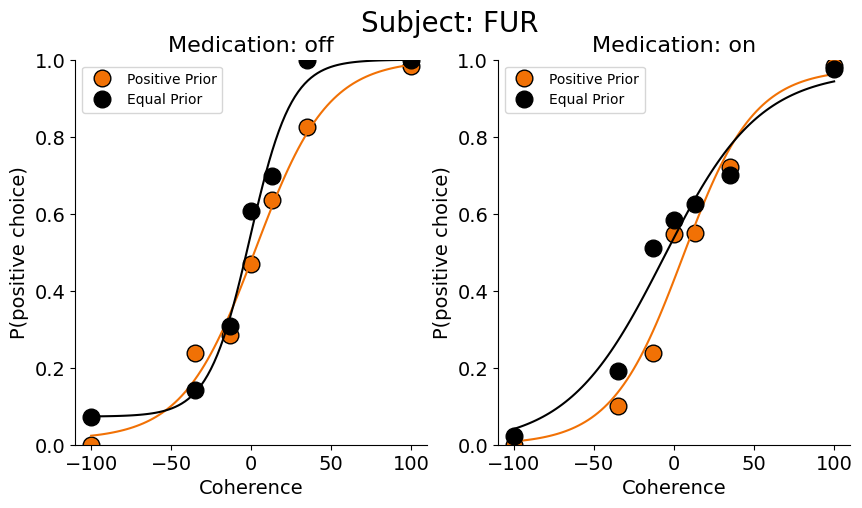

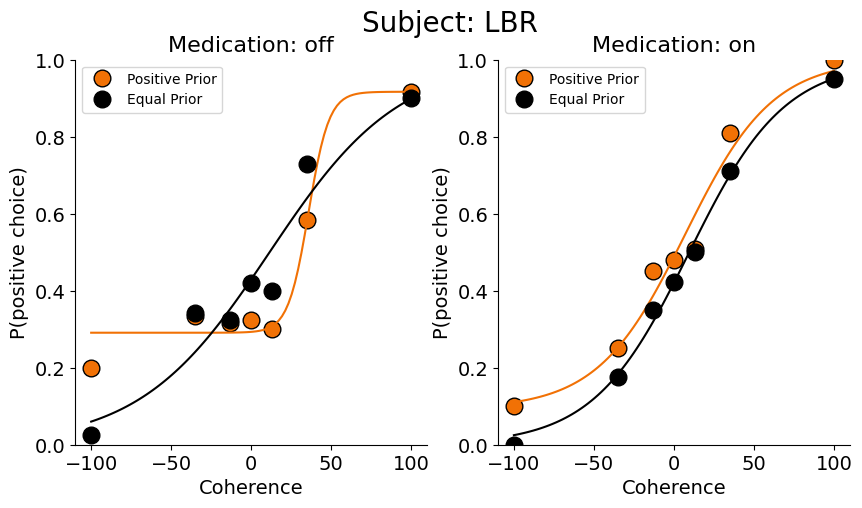

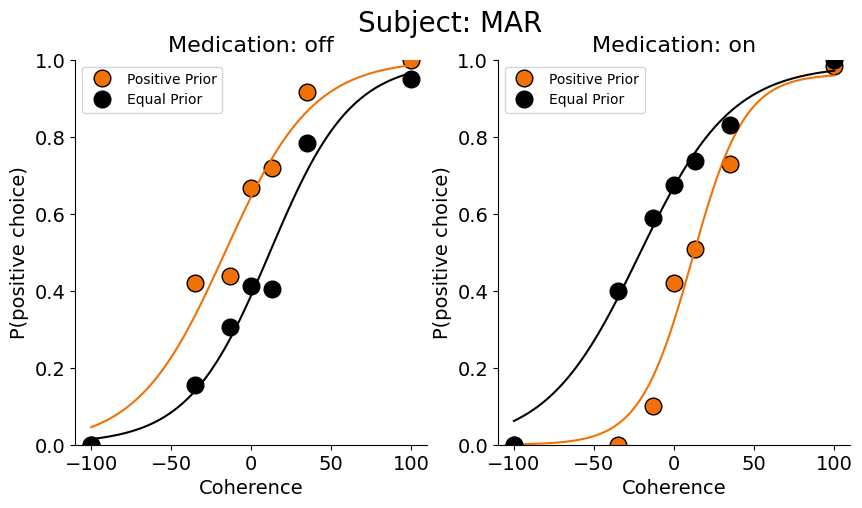

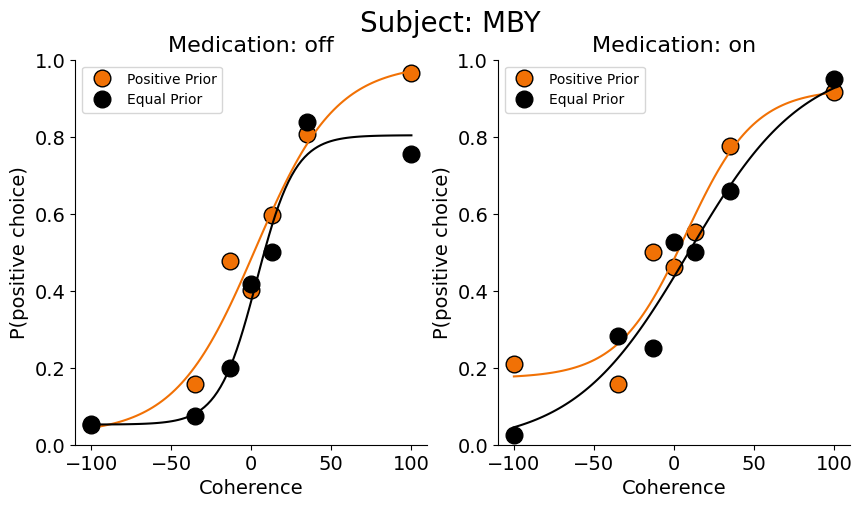

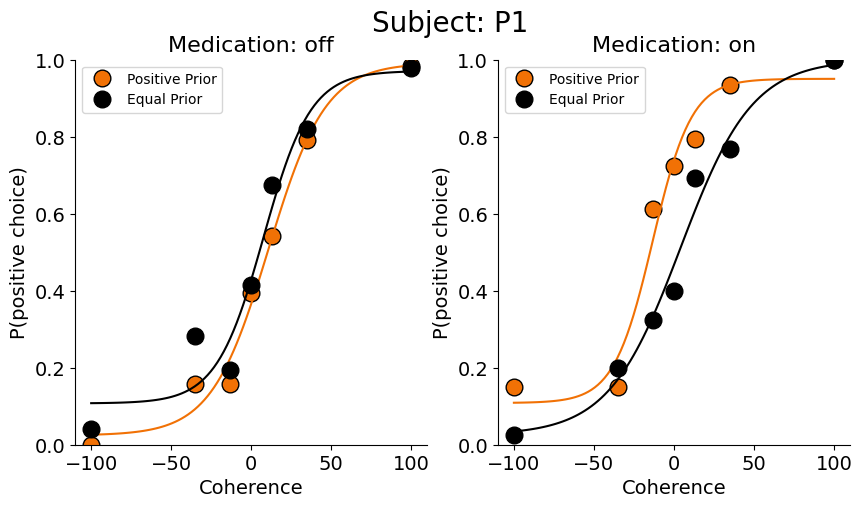

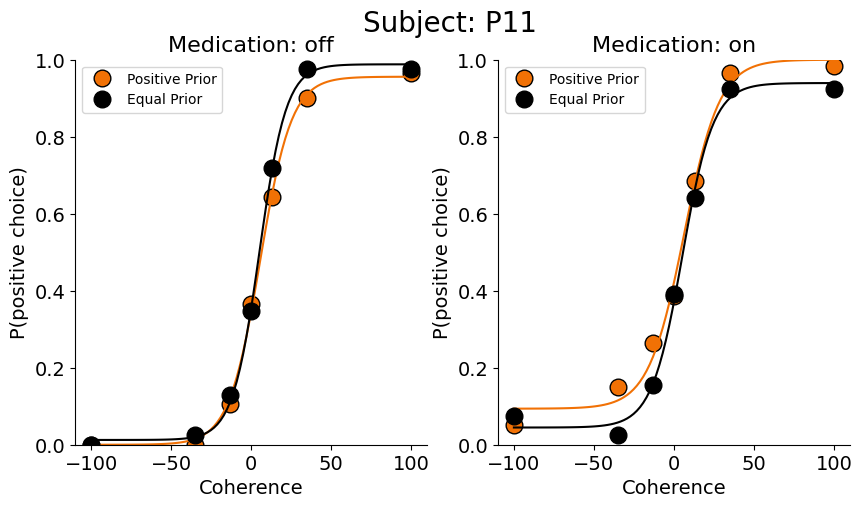

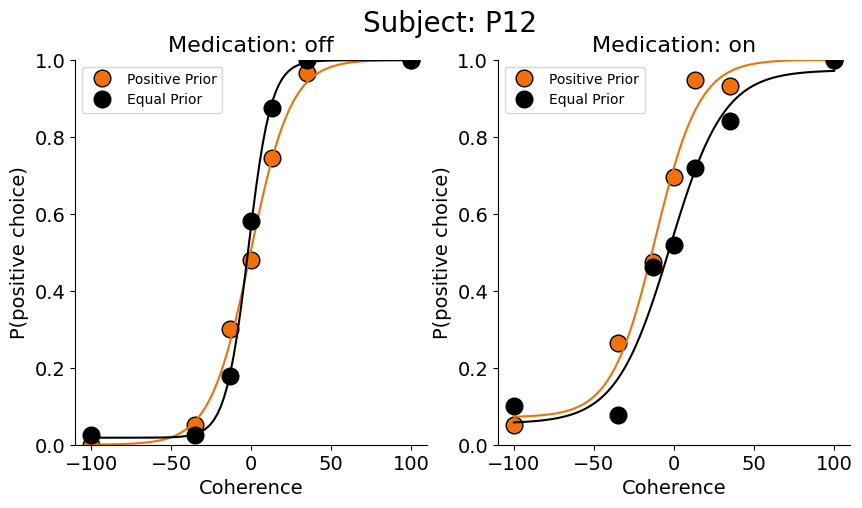

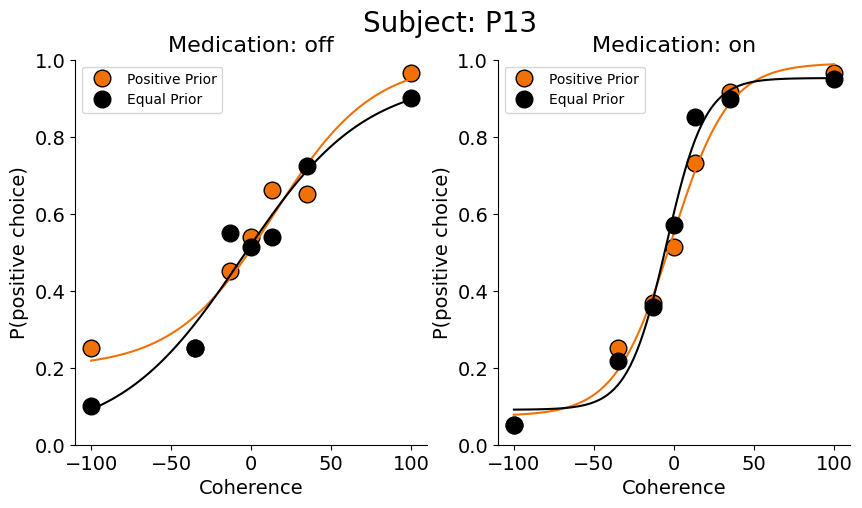

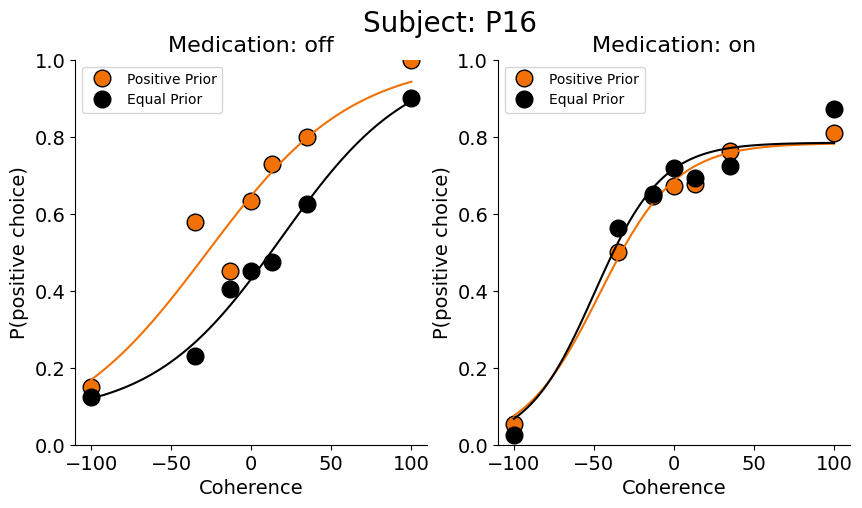

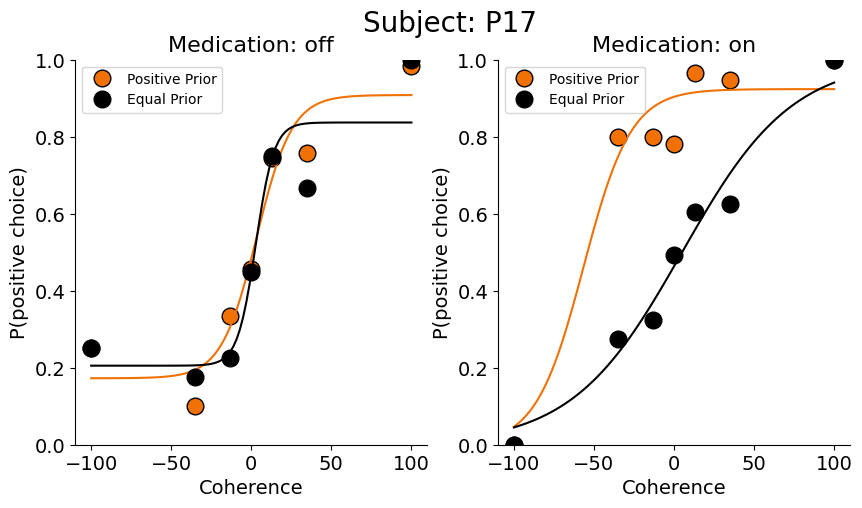

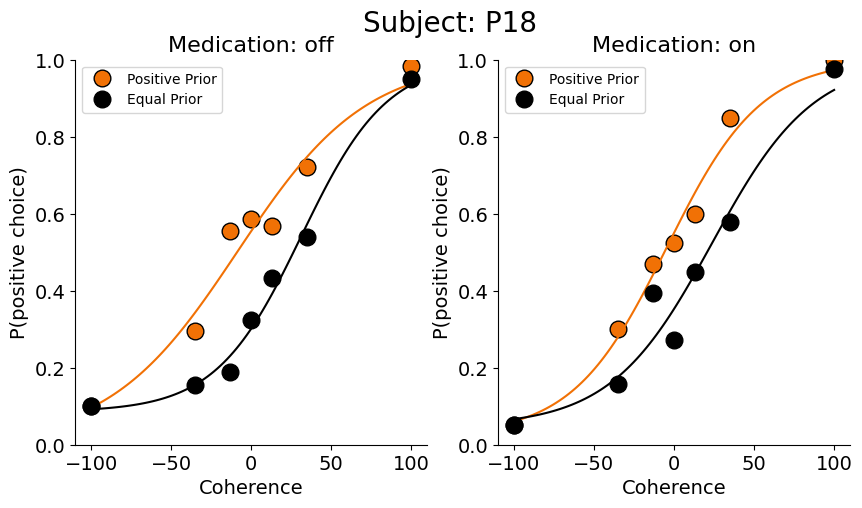

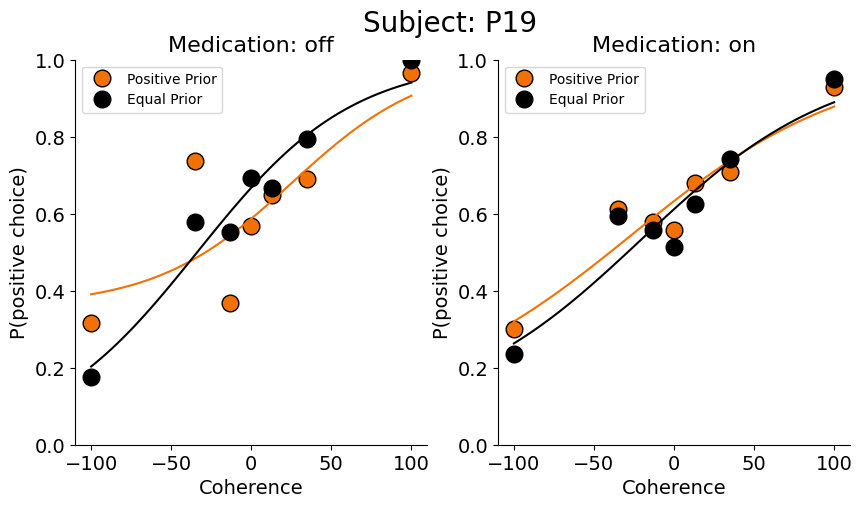

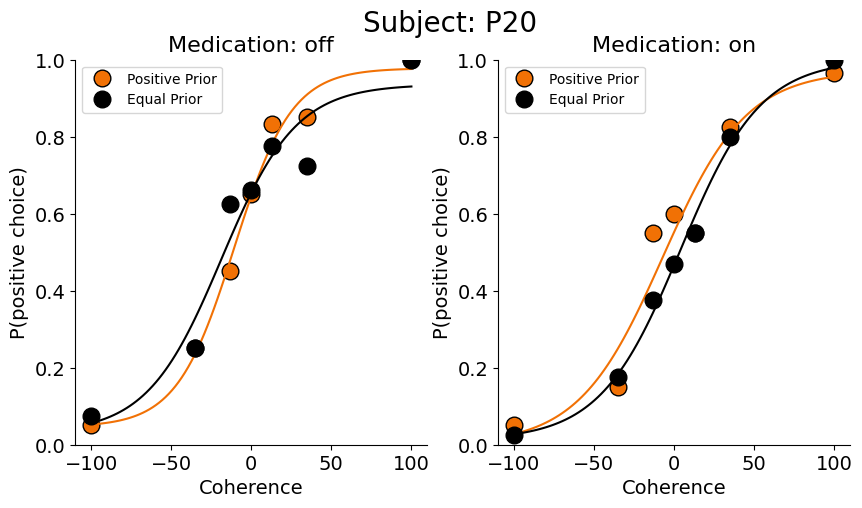

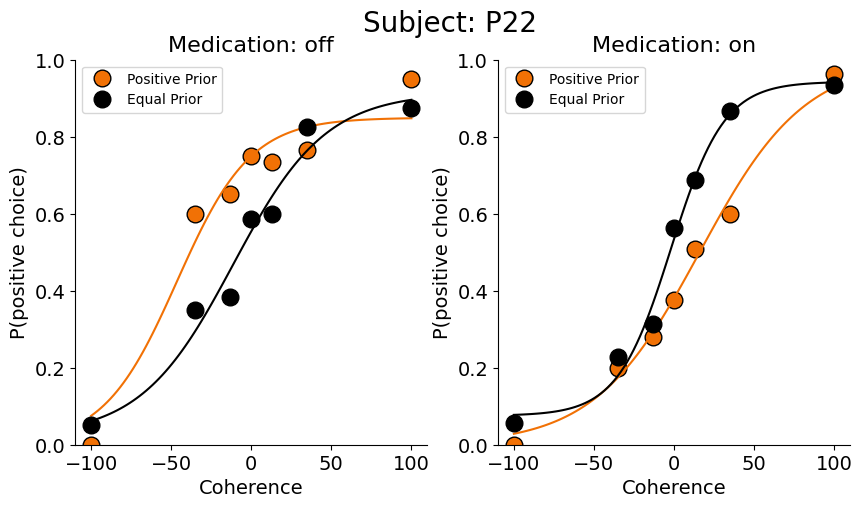

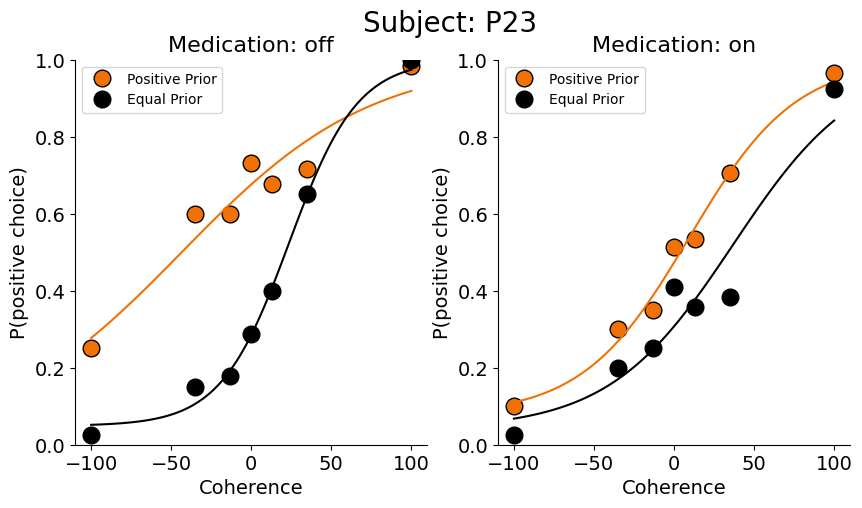

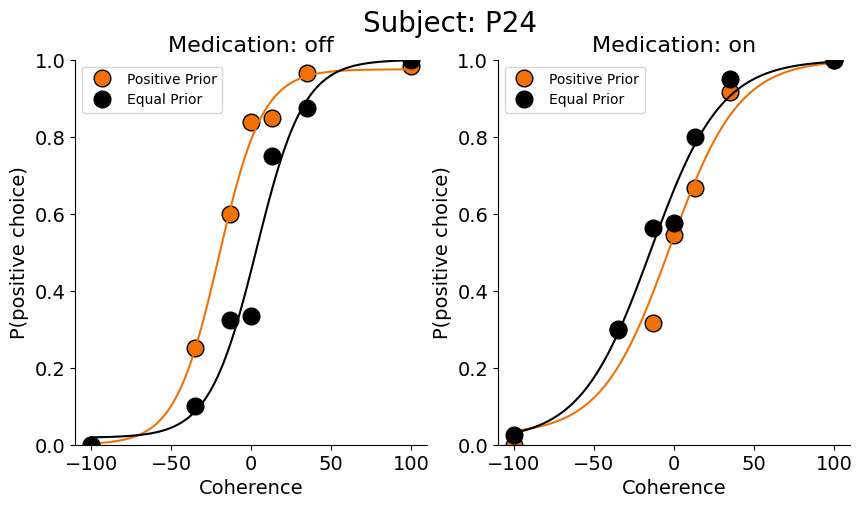

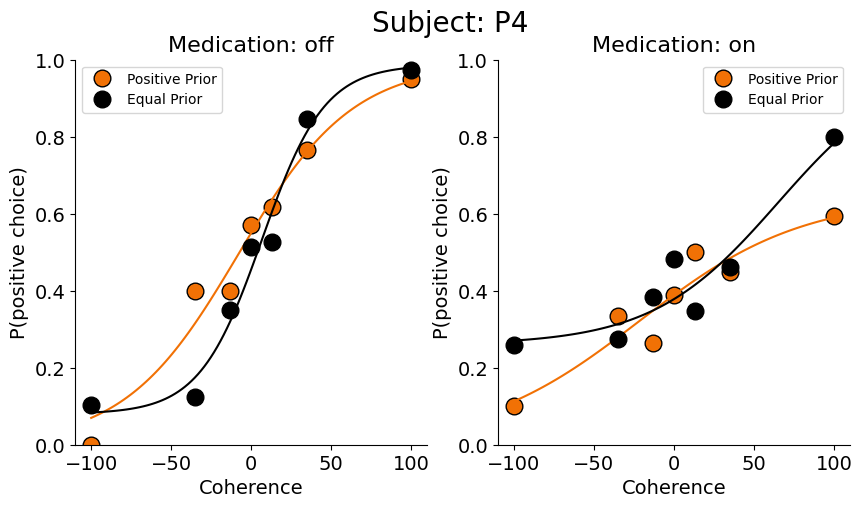

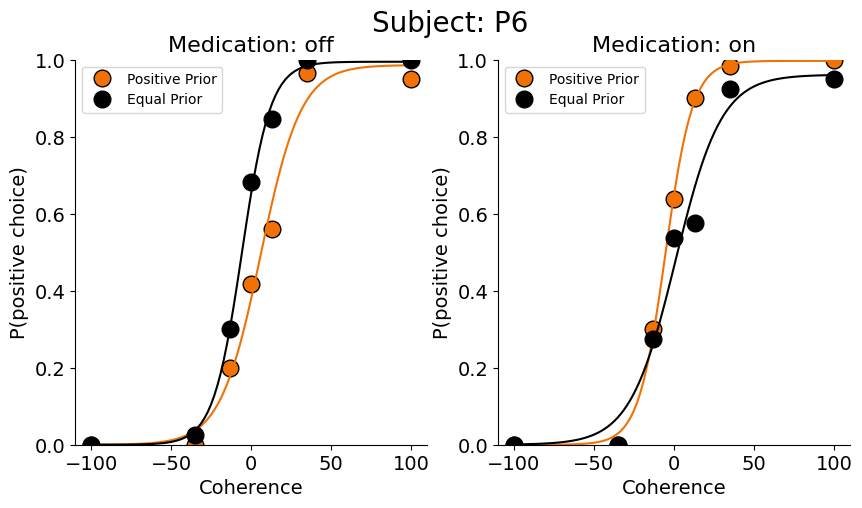

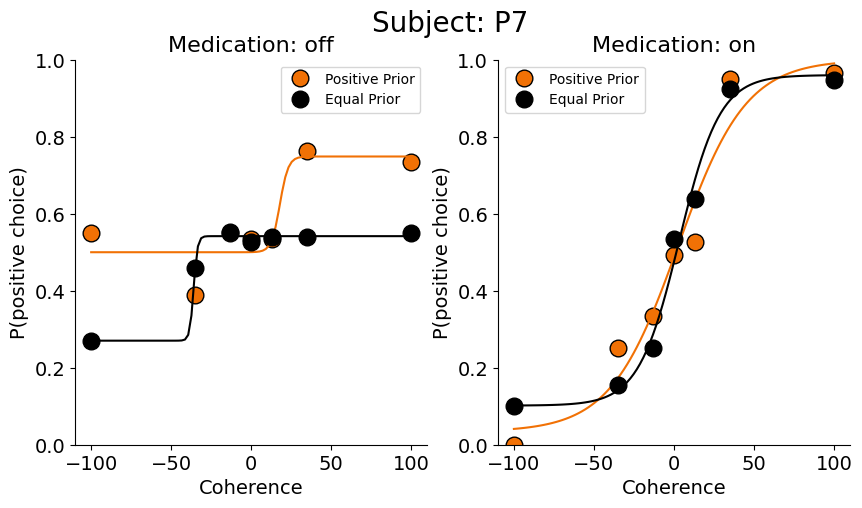

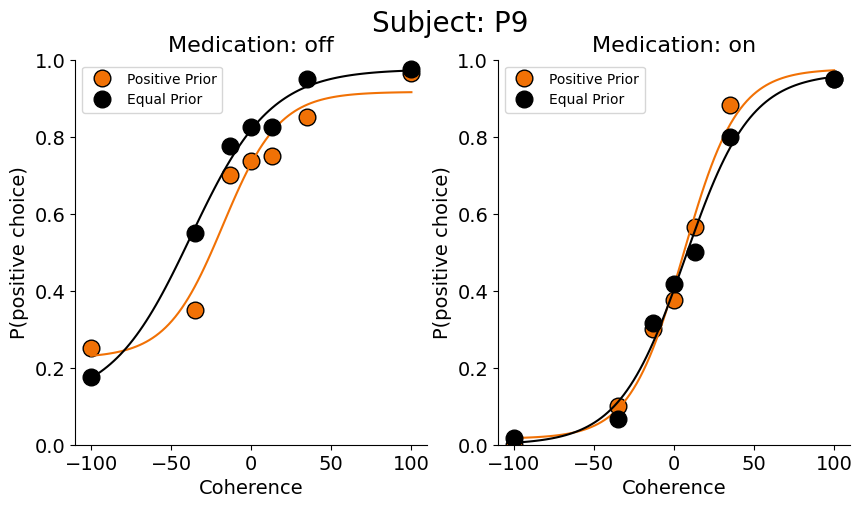

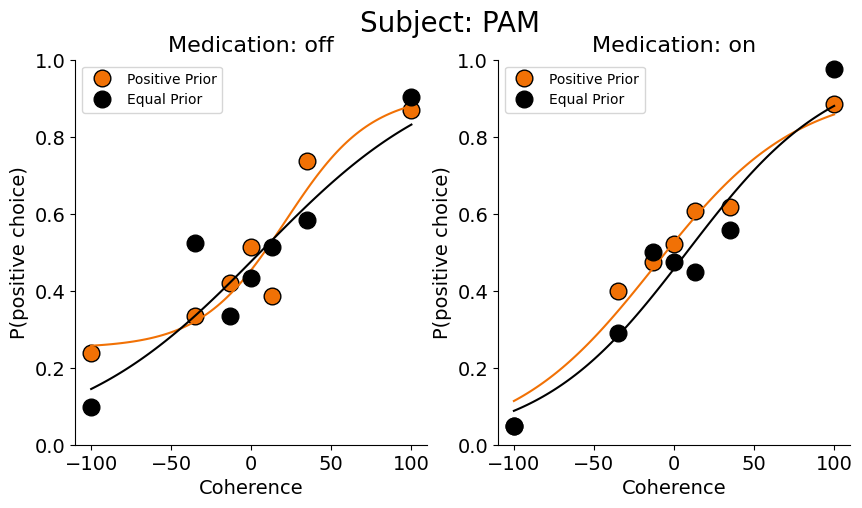

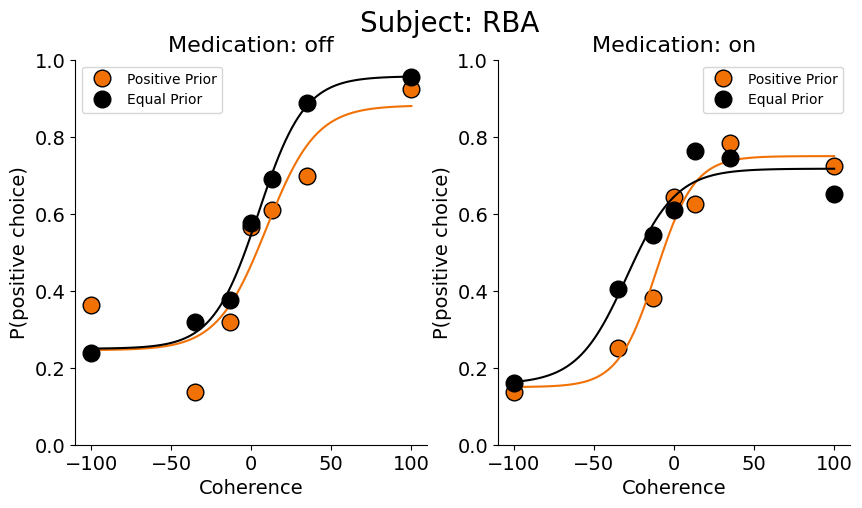

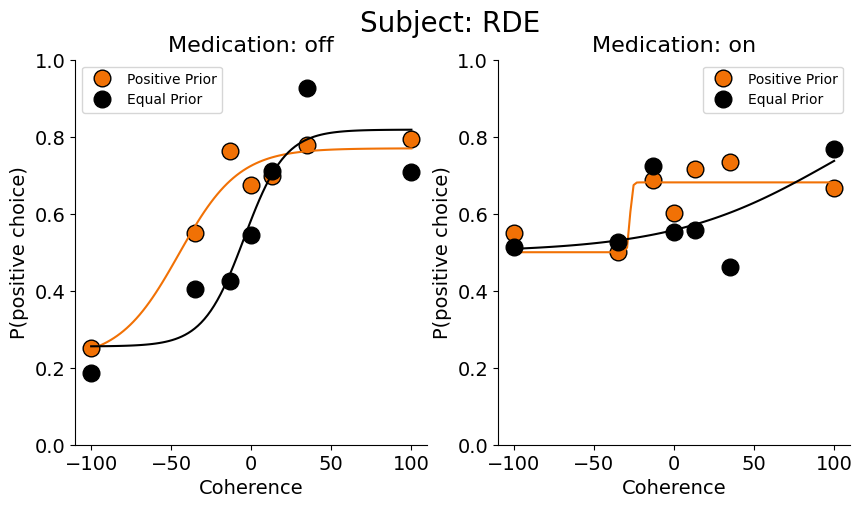

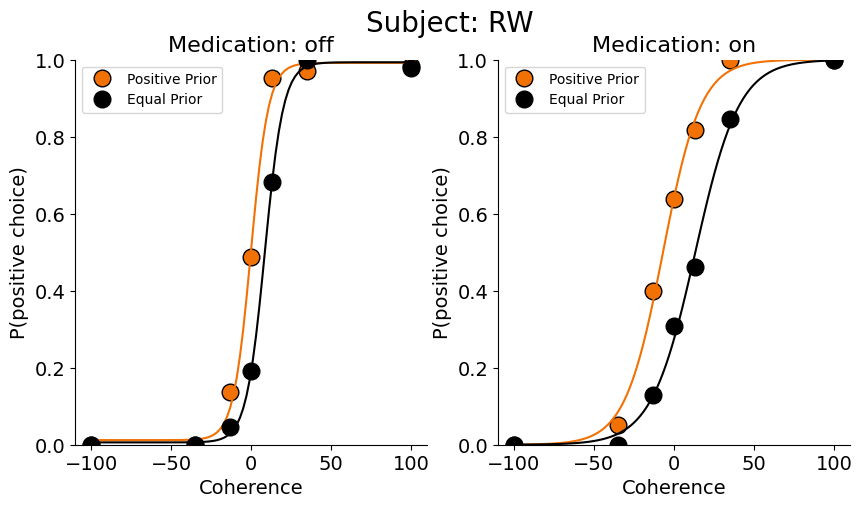

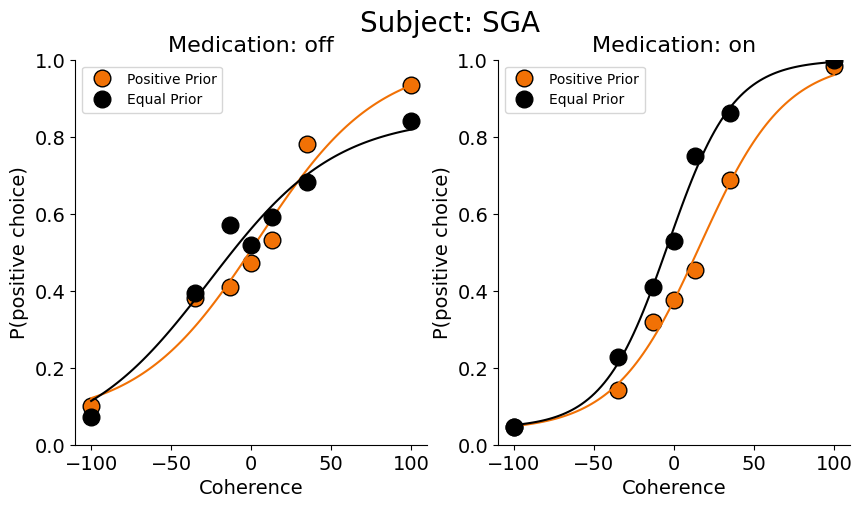

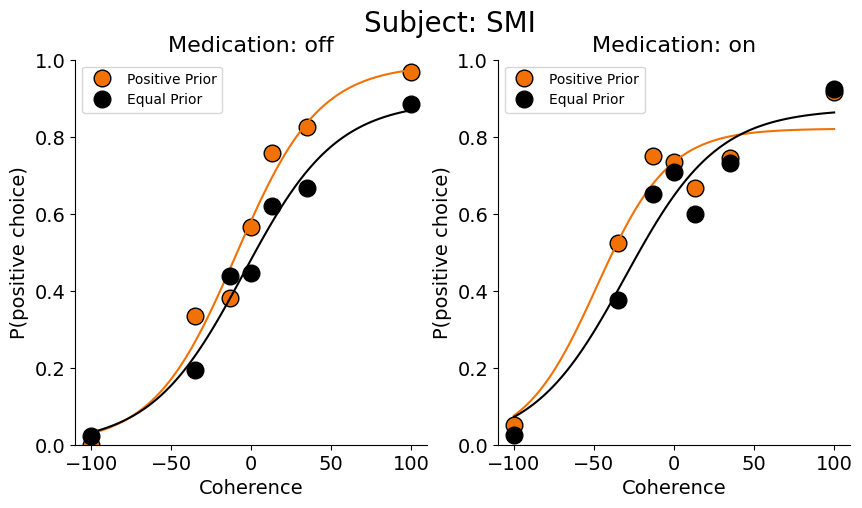

In [31]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

subject_alpha = 0.08
positive_color = 'C5'
equal_color = 'black'
error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

ax[idx].plot(pos_coh, pos_psych, color=positive_color, ls='', alpha=subject_alpha)
ax[idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
ax[idx].plot(eq_coh, eq_psych, color=equal_color, ls='', alpha=subject_alpha)
ax[idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)
        
for i, subject in enumerate(valid_subjects):
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    subject_data = valid_data[valid_data['subject'] == subject]
    subject_data = subject_data.sort_values('medication')
    
    for idx, med in enumerate(subject_data['medication'].unique()):
        med_data = subject_data[subject_data['medication'] == med]
        coh, psych, model, x_hat, y_hat, _ = utils.get_psychometric_data(med_data[med_data['color'] == 1])
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=positive_color, ls='', label='Positive Prior')
        ax[idx].plot(x_hat, y_hat, color=positive_color, ls='-')
        coh, psych, model, x_hat, y_hat, _ = utils.get_psychometric_data(med_data[med_data['color'] == -1])
        ax[idx].plot(coh, psych, marker='o', ms=12, mec='k', color=equal_color, ls='', label='Equal Prior')
        ax[idx].plot(x_hat, y_hat, color=equal_color, ls='-')
        ax[idx].set_title(f"Medication: {med}", fontsize=16)
        ax[idx].set_xlabel('Coherence', fontsize=14)
        ax[idx].set_ylabel('P(positive choice)', fontsize=14)
        ax[idx].legend()
        ax[idx].set_ylim(0, 1)
        ax[idx].tick_params(axis='both', labelsize=14)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        
    fig.suptitle(f"Subject: {subject}", fontsize=20)

#### Final categorization tally

In [32]:
# print(session_metadata['categorization_score'])

# save the session_metadata['categorization'] equal to tremor_dominant if the score is greater than 1, bradykinesia_dominant if the score is less than 0.8 and intermediate if the score is between 0.8 and 1
session_metadata['categorization'] = np.NaN
session_metadata.loc[session_metadata['categorization_score'] > 1, 'categorization'] = 'tremor_dominant'
session_metadata.loc[session_metadata['categorization_score'] < 0.8, 'categorization'] = 'bradykinesia_dominant'
session_metadata.loc[(session_metadata['categorization_score'] >= 0.8) & (session_metadata['categorization_score'] <= 1), 'categorization'] = 'intermediate'

# session_metadata['categorization'].value_counts()

valid_session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]
print(valid_session_metadata['categorization'].value_counts())


# print categorization value count group by subject
print(valid_session_metadata.groupby('subject_id')['categorization'].value_counts())
    


categorization
bradykinesia_dominant    20
tremor_dominant          10
intermediate              2
Name: count, dtype: int64
subject_id  categorization       
P1          bradykinesia_dominant    2
P11         tremor_dominant          2
P12         tremor_dominant          2
P13         bradykinesia_dominant    2
P16         tremor_dominant          2
P17         bradykinesia_dominant    2
P18         intermediate             2
P19         tremor_dominant          2
P20         bradykinesia_dominant    2
P22         bradykinesia_dominant    2
P23         bradykinesia_dominant    2
P24         bradykinesia_dominant    2
P4          bradykinesia_dominant    2
P6          bradykinesia_dominant    2
P7          tremor_dominant          2
P9          bradykinesia_dominant    2
Name: count, dtype: int64


In [33]:
valid_session_metadata['categorization'].values

array(['bradykinesia_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant',
       'tremor_dominant', 'tremor_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'tremor_dominant', 'tremor_dominant',
       'tremor_dominant', 'tremor_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'tremor_dominant', 'tremor_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant', 'intermediate',
       'intermediate', 'tremor_dominant', 'tremor_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant',
       'bradykinesia_dominant', 'bradykinesia_dominant', nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan], dtype=object)

### Save data and data results (metadata)

In [34]:
# move file_name column to the end
cols = session_metadata.columns.tolist()
cols = cols[:4] + cols[5:] + [cols[4]]
session_metadata = session_metadata[cols]


session_metadata = session_metadata[session_metadata['subject_id'].isin(valid_subjects)]
valid_data = valid_data[valid_data['subject'].isin(valid_subjects)]

session_metadata.to_csv(Path(processed_dir, "processed_metadata_60accu_allowed.csv"), index=False)
valid_data.to_csv(Path(processed_dir, "processed_data60accu_allowed.csv"), index=False)